In [12]:
# Colab setup cell (run once)
!pip install --quiet pdfplumber python-docx spacy sentence-transformers faiss-cpu sqlalchemy psycopg2-binary plotly camelot-py
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Task
Extract all tables from the PDF file '/content/VOLUME_II_NON_COAL_2015-FULL.pdf', merging tables that span across multiple pages, and save each complete table as a separate CSV file, named by the starting page number of the table.

## Load PDF

### Subtask:
Load the PDF file '/content/VOLUME_II_NON_COAL_2015-FULL.pdf' using pdfplumber.


**Reasoning**:
I need to import the `pdfplumber` library and then open the specified PDF file to fulfill the subtask.



In [5]:
import pdfplumber

# Open the PDF file
pdf_path = '/content/VOLUME_II_NON_COAL_2015-FULL.pdf'
pdf = pdfplumber.open(pdf_path)

print(f"PDF file '{pdf_path}' loaded successfully.")

PDF file '/content/VOLUME_II_NON_COAL_2015-FULL.pdf' loaded successfully.


## Extract and Merge Tables

### Subtask:
Iterate through each page of the PDF to extract tables and convert them into pandas DataFrames, preparing for the merging logic.


In [15]:
import pandas as pd

# Helper function to clean and normalize headers for comparison
def normalize_headers(headers):
    if headers is None:
        return []
    # Replace None with empty string for consistent comparison
    cleaned_headers = [str(h).replace('\n', ' ').strip() if h is not None else '' for h in headers]
    # Filter out empty strings if they are not meant to be significant columns
    # For this task, we will keep them for column count consistency, but normalize their value
    return cleaned_headers

# Helper function to check if two tables are similar based on their headers
def are_tables_similar(df1, df2):
    if df1 is None or df2 is None:
        return False
    # Compare normalized headers and column count
    headers1 = normalize_headers(df1.columns.tolist())
    headers2 = normalize_headers(df2.columns.tolist())

    # A basic check: same number of columns and similar headers
    # This can be made more robust if needed, e.g., using Jaccard similarity or fuzzy matching
    # For now, a direct comparison of normalized headers should work for exact matches
    return len(headers1) == len(headers2) and headers1 == headers2

# Initialize an empty list to store final merged tables
all_final_tables = []

# Initialize variables for the current table being merged across pages
current_merged_df = None
current_merged_start_page = None

# Iterate through each page of the PDF
for page_index, page in enumerate(pdf.pages):
    if(page_index <= 8 )  :
      continue

    print(f"\n--- Processing Page {page_index + 1} ---")

    # Extract all tables from the current page using pdfplumber's default method
    raw_tables_on_page = page.extract_tables()

    if not raw_tables_on_page:
        print(f"No tables found on page {page_index + 1}.")
        # If no tables on current page and there's a pending merged table, save it.
        if current_merged_df is not None:
            all_final_tables.append({'df': current_merged_df.copy(), 'start_page': current_merged_start_page})
            current_merged_df = None
            current_merged_start_page = None
        continue

    for table_idx, raw_table in enumerate(raw_tables_on_page):
        if not raw_table or not raw_table[0]: # Check if table is empty or header is empty
            print(f"Table {table_idx + 1} on page {page_index + 1} is empty or has no header, skipping.")
            continue

        # Assume the first row is the header
        headers = raw_table[0]
        data = raw_table[1:]

        # Create DataFrame from current raw table
        df = pd.DataFrame(data, columns=headers)

        # Remove rows that are entirely empty (e.g., from table extraction artifacts)
        df.dropna(how='all', inplace=True)

        if df.empty:
            print(f"Table {table_idx + 1} on page {page_index + 1} became empty after dropping NaNs, skipping.")
            continue

        print(f"Extracted Table {table_idx + 1} from page {page_index + 1}.")
        print("DataFrame head:\n", df.head())
        print("DataFrame columns:\n", df.columns.tolist())
        print("DataFrame shape:", df.shape)

        # Merging logic
        if current_merged_df is None:
            # Start a new merged table
            current_merged_df = df
            current_merged_start_page = page_index + 1
            print(f"Started new merged table from page {page_index + 1}.")
        elif are_tables_similar(current_merged_df, df): # Check if current table is a continuation
            # If similar, append data to the current merged DataFrame
            # We need to make sure column names are exactly the same before appending
            # Use normalized headers to align columns if they differ slightly due to extraction
            current_merged_df.columns = normalize_headers(current_merged_df.columns.tolist())
            df.columns = normalize_headers(df.columns.tolist())

            # Ensure columns match for concatenation
            if list(current_merged_df.columns) == list(df.columns):
                current_merged_df = pd.concat([current_merged_df, df], ignore_index=True)
                print(f"Merged table data from page {page_index + 1}.")
            else:
                print(f"Column mismatch for merging on page {page_index + 1}. Saving current merged table and starting new one.")
                all_final_tables.append({'df': current_merged_df.copy(), 'start_page': current_merged_start_page})
                current_merged_df = df
                current_merged_start_page = page_index + 1
        else:
            # If not similar, save the current merged table and start a new one
            all_final_tables.append({'df': current_merged_df.copy(), 'start_page': current_merged_start_page})
            current_merged_df = df
            current_merged_start_page = page_index + 1
            print(f"Saved previous merged table and started new one from page {page_index + 1}.")

# After iterating through all pages, save any pending merged table
if current_merged_df is not None:
    all_final_tables.append({'df': current_merged_df.copy(), 'start_page': current_merged_start_page})
    print(f"Saved final pending merged table from page {current_merged_start_page}.")

print(f"\nTotal {len(all_final_tables)} complete tables extracted and merged.")


--- Processing Page 10 ---
No tables found on page 10.

--- Processing Page 11 ---
Extracted Table 1 from page 11.
DataFrame head:
    Mineral  Year No. of mines\nsubmitting\nreturns Average daily employment  \
0     None  None                              None             Below ground   
1      (1)   (2)                               (3)                      (4)   
2  Bauxite  1961                                31                       --   
3     None  1971                                58                       14   
4     None  1981                                48                       --   

                 None           None   None Output\n(in ’000\ntonnes)  \
0  Opencast\nworkings  Above\nground  Total                      None   
1                 (5)            (6)    (7)                       (8)   
2               2,745            301  3,046                      476*   
3               4,128            673  4,815                     1,449   
4               3,586      

**Reasoning**:
The previous step successfully extracted and merged tables across multiple pages. Now, I need to iterate through the `all_final_tables` list and save each DataFrame as a separate CSV file, using the corresponding `start_page` as part of the filename, as per the task requirements.



In [17]:
import os
import shutil

# Create a directory to save the CSV files if it doesn't exist
output_dir = "extracted_tables"

# Remove the directory and its contents if it already exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Removed existing directory: '{output_dir}'")

os.makedirs(output_dir, exist_ok=True)
print(f"Created fresh directory: '{output_dir}'")

# Save each merged DataFrame to a CSV file
for i, table_info in enumerate(all_final_tables):
    df_to_save = table_info['df']
    start_page = table_info['start_page']
    filename = os.path.join(output_dir, f"table_page_{start_page}.csv")

    # Ensure headers are strings for consistent CSV output
    df_to_save.columns = [str(col) for col in df_to_save.columns]

    df_to_save.to_csv(filename, index=False)
    print(f"Saved table starting on page {start_page} to {filename}")

print(f"All {len(all_final_tables)} tables saved successfully to the '{output_dir}' directory.")

Removed existing directory: 'extracted_tables'
Created fresh directory: 'extracted_tables'
Saved table starting on page 11 to extracted_tables/table_page_11.csv
Saved table starting on page 57 to extracted_tables/table_page_57.csv
Saved table starting on page 83 to extracted_tables/table_page_83.csv
Saved table starting on page 101 to extracted_tables/table_page_101.csv
All 4 tables saved successfully to the 'extracted_tables' directory.


# Task
List all CSV files in the 'extracted_tables' directory.

## List Available CSVs

### Subtask:
List all CSV files present in the 'extracted_tables' directory to identify which ones to work with.


**Reasoning**:
I need to import the `os` module, define the directory path, list its contents, filter for CSV files, and then print the list of identified CSV files to complete the subtask.



In [18]:
import os

# Define the directory path
directory_path = 'extracted_tables'

# List all entries in the directory
all_entries = os.listdir(directory_path)

# Filter for files ending with '.csv'
csv_files = [file for file in all_entries if file.endswith('.csv')]

# Print the list of identified CSV files
if csv_files:
    print(f"CSV files found in '{directory_path}':")
    for csv_file in csv_files:
        print(f"- {csv_file}")
else:
    print(f"No CSV files found in '{directory_path}'.")

CSV files found in 'extracted_tables':
- table_page_101.csv
- table_page_57.csv
- table_page_11.csv
- table_page_83.csv


## Load and Inspect Selected CSVs

### Subtask:
Load data from 'extracted_tables/table_page_11.csv' and 'extracted_tables/table_page_57.csv' into pandas DataFrames. Display their headers, columns, and basic information to understand their structure and content.


**Reasoning**:
I need to import the pandas library, load the two specified CSV files into separate DataFrames, and then display the head, columns, and info for each DataFrame to understand their structure and content.



In [19]:
import pandas as pd

# Load the CSV file 'extracted_tables/table_page_11.csv' into a DataFrame named df_page_11
df_page_11 = pd.read_csv('extracted_tables/table_page_11.csv')
print("\n--- DataFrame from table_page_11.csv ---")
print("Head:\n", df_page_11.head())
print("Columns:", df_page_11.columns.tolist())
df_page_11.info()

# Load the CSV file 'extracted_tables/table_page_57.csv' into a DataFrame named df_page_57
df_page_57 = pd.read_csv('extracted_tables/table_page_57.csv')
print("\n--- DataFrame from table_page_57.csv ---")
print("Head:\n", df_page_57.head())
print("Columns:", df_page_57.columns.tolist())
df_page_57.info()


--- DataFrame from table_page_11.csv ---
Head:
    Mineral  Year No. of mines submitting returns Average daily employment  \
0      NaN   NaN                             NaN             Below ground   
1      (1)   (2)                             (3)                      (4)   
2  Bauxite  1961                              31                       --   
3      NaN  1971                              58                       14   
4      NaN  1981                              48                       --   

           Unnamed: 4     Unnamed: 5 Unnamed: 6 Output (in ’000 tonnes)  \
0  Opencast\nworkings  Above\nground      Total                     NaN   
1                 (5)            (6)        (7)                     (8)   
2               2,745            301      3,046                    476*   
3               4,128            673      4,815                   1,449   
4               3,586            731      4,317                   1,747   

  Value of output (in million Rs.)  


## Clean and Prepare Data (Table from Page 11)

### Subtask:
Clean and preprocess the DataFrame loaded from 'table_page_11.csv'. This will involve renaming columns for clarity, removing irrelevant header rows, converting 'Year' to numeric, and handling other numerical columns for visualization and prediction. The goal is to prepare a subset of this table (e.g., for 'Bauxite' mineral) for time-series analysis.


**Reasoning**:
I need to perform several data cleaning and preprocessing steps on `df_page_11` to prepare it for analysis, including renaming columns, removing irrelevant rows, filtering for a specific mineral, and converting various columns to numeric types.



In [20]:
import numpy as np

# 1. Define new descriptive column names
new_column_names = [
    'Mineral',
    'Year',
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (\u2019000 tonnes)',
    'Value of output (million Rs.)'
]

# 2. Assign new column names
df_page_11.columns = new_column_names
print("Columns renamed successfully.")

# 3. Drop the first two rows (index 0 and 1)
df_page_11 = df_page_11.drop([0, 1])
print("First two rows dropped.")

# 4. Reset the index of the DataFrame
df_page_11 = df_page_11.reset_index(drop=True)
print("DataFrame index reset.")

# 5. Filter for 'Bauxite' mineral
df_bauxite = df_page_11[df_page_11['Mineral'] == 'Bauxite'].copy()
print("Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.")

# 6. Clean and convert 'Year' to numeric
df_bauxite['Year'] = df_bauxite['Year'].astype(str).str.replace(r'[^\d]', '', regex=True)
df_bauxite['Year'] = pd.to_numeric(df_bauxite['Year'], errors='coerce')
df_bauxite.dropna(subset=['Year'], inplace=True)
df_bauxite['Year'] = df_bauxite['Year'].astype(int)
print("'Year' column cleaned and converted to numeric.")

# 7. Identify numerical columns requiring cleaning
numerical_cols_to_clean = [
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (\u2019000 tonnes)',
    'Value of output (million Rs.)'
]

# 8. Clean and convert numerical columns to float
for col in numerical_cols_to_clean:
    # Ensure the column is string type before applying string operations
    df_bauxite[col] = df_bauxite[col].astype(str)
    # Remove characters like '*', ',', '-' and then convert to numeric
    df_bauxite[col] = df_bauxite[col].str.replace('[*,\u2019\s-]', '', regex=True)
    df_bauxite[col] = pd.to_numeric(df_bauxite[col], errors='coerce')
print("Numerical columns cleaned and converted to float.")

# 9. Fill any remaining NaN values in numerical columns with 0
for col in numerical_cols_to_clean:
    df_bauxite[col] = df_bauxite[col].fillna(0)
print("NaN values in numerical columns filled with 0.")

# 10. Display the first few rows, column names, and info of the cleaned df_bauxite
print("\n--- Cleaned df_bauxite DataFrame ---")
print("Head:\n", df_bauxite.head())
print("Columns:\n", df_bauxite.columns.tolist())
df_bauxite.info()

Columns renamed successfully.
First two rows dropped.
DataFrame index reset.
Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.
'Year' column cleaned and converted to numeric.
Numerical columns cleaned and converted to float.
NaN values in numerical columns filled with 0.

--- Cleaned df_bauxite DataFrame ---
Head:
    Mineral  Year  No. of mines submitting returns  \
0  Bauxite  1961                               31   

   Average daily employment - Below ground  \
0                                      0.0   

   Average daily employment - Opencast workings  \
0                                          2745   

   Average daily employment - Above ground  Average daily employment - Total  \
0                                      301                              3046   

   Output (’000 tonnes)  Value of output (million Rs.)  
0                   476                              5  
Columns:
 ['Mineral', 'Year', 'No. of mines submitting returns', 'Average daily employmen

<>:55: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3039698738.py:55: SyntaxWarning: invalid escape sequence '\s'
  df_bauxite[col] = df_bauxite[col].str.replace('[*,\u2019\s-]', '', regex=True)


**Reasoning**:
The previous code resulted in `df_bauxite` having only one row because the 'Mineral' column had `NaN` values for subsequent entries belonging to the same mineral. I need to forward-fill the 'Mineral' column before filtering to correctly capture all rows related to 'Bauxite'.



In [21]:
import numpy as np

# 1. Define new descriptive column names
new_column_names = [
    'Mineral',
    'Year',
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (’000 tonnes)',
    'Value of output (million Rs.)'
]

# 2. Assign new column names
df_page_11.columns = new_column_names
print("Columns renamed successfully.")

# 3. Drop the first two rows (index 0 and 1)
df_page_11 = df_page_11.drop([0, 1])
print("First two rows dropped.")

# 4. Reset the index of the DataFrame
df_page_11 = df_page_11.reset_index(drop=True)
print("DataFrame index reset.")

# Fill NaN values in 'Mineral' column with the last valid mineral name
df_page_11['Mineral'] = df_page_11['Mineral'].ffill()
print("Filled NaN values in 'Mineral' column.")

# 5. Filter for 'Bauxite' mineral
df_bauxite = df_page_11[df_page_11['Mineral'] == 'Bauxite'].copy()
print("Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.")

# 6. Clean and convert 'Year' to numeric
df_bauxite['Year'] = df_bauxite['Year'].astype(str).str.replace(r'[^\d]', '', regex=True)
df_bauxite['Year'] = pd.to_numeric(df_bauxite['Year'], errors='coerce')
df_bauxite.dropna(subset=['Year'], inplace=True)
df_bauxite['Year'] = df_bauxite['Year'].astype(int)
print("'Year' column cleaned and converted to numeric.")

# 7. Identify numerical columns requiring cleaning
numerical_cols_to_clean = [
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (’000 tonnes)',
    'Value of output (million Rs.)'
]

# 8. Clean and convert numerical columns to float
for col in numerical_cols_to_clean:
    # Ensure the column is string type before applying string operations
    df_bauxite[col] = df_bauxite[col].astype(str)
    # Remove characters like '*', ',', '-' and then convert to numeric
    df_bauxite[col] = df_bauxite[col].str.replace('[*,\u2019\s-]', '', regex=True)
    df_bauxite[col] = pd.to_numeric(df_bauxite[col], errors='coerce')
print("Numerical columns cleaned and converted to float.")

# 9. Fill any remaining NaN values in numerical columns with 0
for col in numerical_cols_to_clean:
    df_bauxite[col] = df_bauxite[col].fillna(0)
print("NaN values in numerical columns filled with 0.")

# 10. Display the first few rows, column names, and info of the cleaned df_bauxite
print("\n--- Cleaned df_bauxite DataFrame ---")
print("Head:\n", df_bauxite.head())
print("Columns:\n", df_bauxite.columns.tolist())
df_bauxite.info()


Columns renamed successfully.
First two rows dropped.
DataFrame index reset.
Filled NaN values in 'Mineral' column.
Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.
'Year' column cleaned and converted to numeric.
Numerical columns cleaned and converted to float.
NaN values in numerical columns filled with 0.

--- Cleaned df_bauxite DataFrame ---
Head:
 Empty DataFrame
Columns: [Mineral, Year, No. of mines submitting returns, Average daily employment - Below ground, Average daily employment - Opencast workings, Average daily employment - Above ground, Average daily employment - Total, Output (’000 tonnes), Value of output (million Rs.)]
Index: []
Columns:
 ['Mineral', 'Year', 'No. of mines submitting returns', 'Average daily employment - Below ground', 'Average daily employment - Opencast workings', 'Average daily employment - Above ground', 'Average daily employment - Total', 'Output (’000 tonnes)', 'Value of output (million Rs.)']
<class 'pandas.core.frame.DataFrame'>

<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-122666114.py:59: SyntaxWarning: invalid escape sequence '\s'
  df_bauxite[col] = df_bauxite[col].str.replace('[*,\u2019\s-]', '', regex=True)


**Reasoning**:
The `df_bauxite` DataFrame was empty because the `df_page_11` in the kernel state did not contain 'Bauxite' at the expected starting row after previous cleaning attempts, leading to `ffill()` not being able to propagate any 'Mineral' value. To resolve this, I need to re-load `df_page_11` from the CSV and apply the initial cleaning steps (column renaming, row dropping, index resetting) to ensure it's in the correct state before performing the `ffill()` and filtering for 'Bauxite'. I will also fix the `SyntaxWarning` for the regex in `str.replace`.



In [22]:
import numpy as np
import pandas as pd # Import pandas as it might be needed if the kernel was restarted or df_page_11 is truly 'broken'

# Re-load the CSV to ensure df_page_11 is in its original state before cleaning
df_page_11 = pd.read_csv('extracted_tables/table_page_11.csv')
print("df_page_11 re-loaded from CSV.")

# 1. Define new descriptive column names
new_column_names = [
    'Mineral',
    'Year',
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (’000 tonnes)',
    'Value of output (million Rs.)'
]

# 2. Assign new column names
df_page_11.columns = new_column_names
print("Columns renamed successfully.")

# 3. Drop the first two rows (index 0 and 1) which contain header remnants and footnotes
df_page_11 = df_page_11.drop([0, 1])
print("First two rows dropped.")

# 4. Reset the index of the DataFrame
df_page_11 = df_page_11.reset_index(drop=True)
print("DataFrame index reset.")

# Fill NaN values in 'Mineral' column with the last valid mineral name for correct filtering
df_page_11['Mineral'] = df_page_11['Mineral'].ffill()
print("Filled NaN values in 'Mineral' column.")

# 5. Filter for 'Bauxite' mineral
df_bauxite = df_page_11[df_page_11['Mineral'] == 'Bauxite'].copy()
print("Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.")

# 6. Clean and convert 'Year' to numeric
df_bauxite['Year'] = df_bauxite['Year'].astype(str).str.replace(r'[^\d]', '', regex=True)
df_bauxite['Year'] = pd.to_numeric(df_bauxite['Year'], errors='coerce')
df_bauxite.dropna(subset=['Year'], inplace=True)
df_bauxite['Year'] = df_bauxite['Year'].astype(int)
print("'Year' column cleaned and converted to numeric.")

# 7. Identify numerical columns requiring cleaning
numerical_cols_to_clean = [
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (’000 tonnes)',
    'Value of output (million Rs.)'
]

# 8. Clean and convert numerical columns to float
for col in numerical_cols_to_clean:
    # Ensure the column is string type before applying string operations
    df_bauxite[col] = df_bauxite[col].astype(str)
    # Remove characters like '*', ',', '-', unicode quote, and any whitespace then convert to numeric
    df_bauxite[col] = df_bauxite[col].str.replace(r'[*,\u2019\s-]', '', regex=True)
    df_bauxite[col] = pd.to_numeric(df_bauxite[col], errors='coerce')
print("Numerical columns cleaned and converted to float.")

# 9. Fill any remaining NaN values in numerical columns with 0
for col in numerical_cols_to_clean:
    df_bauxite[col] = df_bauxite[col].fillna(0)
print("NaN values in numerical columns filled with 0.")

# 10. Display the first few rows, column names, and info of the cleaned df_bauxite
print("\n--- Cleaned df_bauxite DataFrame ---")
print("Head:\n", df_bauxite.head())
print("Columns:\n", df_bauxite.columns.tolist())
df_bauxite.info()

df_page_11 re-loaded from CSV.
Columns renamed successfully.
First two rows dropped.
DataFrame index reset.
Filled NaN values in 'Mineral' column.
Filtered for 'Bauxite' mineral. New DataFrame df_bauxite created.
'Year' column cleaned and converted to numeric.
Numerical columns cleaned and converted to float.
NaN values in numerical columns filled with 0.

--- Cleaned df_bauxite DataFrame ---
Head:
    Mineral  Year  No. of mines submitting returns  \
0  Bauxite  1961                               31   
1  Bauxite  1971                               58   
2  Bauxite  1981                               48   
3  Bauxite  1991                               80   
4  Bauxite  2000                              100   

   Average daily employment - Below ground  \
0                                      0.0   
1                                     14.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

 

## Visualize Trends (Table from Page 11)

### Subtask:
Generate a line plot to visualize the trend of 'Output (in ’000 tonnes)' and 'Value of output (in million Rs.)' over 'Year' for a specific mineral (e.g., 'Bauxite') from the cleaned data. The plot will include appropriate labels and a legend.


**Reasoning**:
I need to import `matplotlib.pyplot`, create a line plot to visualize the trend of 'Output ('000 tonnes)' and 'Value of output (million Rs.)' over 'Year' for 'Bauxite' from `df_bauxite`, and add appropriate labels, a title, and a legend.



## Generate Basic Predictions (Table from Page 11)

### Subtask:
Perform a simple time-series prediction for the 'Output' using a basic forecasting method (e.g., a simple moving average or linear regression) for the selected mineral. Visualize these predictions alongside the historical data.


**Reasoning**:
I need to perform a time-series prediction using linear regression. This involves importing `LinearRegression` and `matplotlib.pyplot`, preparing the data with a `time_index`, fitting the model, making predictions, and then visualizing the historical and predicted output.



# Task
Modify the code to convert `future_time_indices` into a pandas DataFrame with the correct column name ('time_index') before passing it to the `model.predict()` function. This will align the feature names used for prediction with those used during model fitting, thereby resolving the `UserWarning`. Then, re-run the prediction and plot the results, ensuring the `UserWarning` is no longer present and the prediction plot is displayed correctly.

## Correct Prediction Input

### Subtask:
Modify the code to convert `future_time_indices` into a pandas DataFrame with the correct column name ('time_index') before passing it to the `model.predict()` function.


**Reasoning**:
I need to modify the previous code to convert `future_time_indices` into a pandas DataFrame with the column name 'time_index' before passing it to `model.predict()` to resolve the `UserWarning` and ensure correct input format for the model.



## Final Task

### Subtask:
Confirm that the `UserWarning` has been resolved and the prediction plot is displayed correctly.


## Summary:

### Q&A
The `UserWarning` regarding feature names has been successfully resolved by converting `future_time_indices` into a pandas DataFrame with the column name 'time_index' before prediction. The prediction plot is now displayed correctly.

### Data Analysis Key Findings
*   A Linear Regression model was successfully fitted to the historical bauxite output data.
*   Future predictions for bauxite output were generated for 5 years beyond the last historical year.
*   The critical `UserWarning`, which arose from a mismatch in feature names between training and prediction phases, was resolved by ensuring the prediction input (`future_time_indices`) was provided as a pandas DataFrame with the correct column name ('time_index').
*   A plot visualizing both historical and predicted bauxite output was generated, correctly displaying the model's projections.

### Insights or Next Steps
*   Ensuring consistency in feature naming (e.g., column names for DataFrames) between model training and prediction is crucial for avoiding warnings and potential errors, especially with libraries like scikit-learn.
*   The generated plot provides a clear visual representation of the linear trend identified by the model, which can be used for initial forecasting.


# Task
Calculate a 'price_ratio' for 'Bauxite' in `df_bauxite` by dividing 'Value of output (million Rs.)' by 'Output (’000 tonnes)', handling division-by-zero by replacing infinite values with zero.

## Calculate Price Ratio

### Subtask:
Calculate a 'price_ratio' for 'Bauxite' by dividing 'Value of output (million Rs.)' by 'Output (’000 tonnes)' in the `df_bauxite` DataFrame. Handle any potential division-by-zero scenarios by replacing infinite values with zero.


**Reasoning**:
I need to calculate the 'price_ratio' column in `df_bauxite` by dividing 'Value of output (million Rs.)' by 'Output (\u2019000 tonnes)', and then handle any infinite values by replacing them with 0.



In [34]:
import numpy as np

# 1. Calculate 'price_ratio'
df_bauxite['price_ratio'] = df_bauxite['Value of output (million Rs.)'] / df_bauxite['Output (\u2019000 tonnes)']
print("Calculated 'price_ratio' column.")

# 2. Replace infinite values with 0
df_bauxite['price_ratio'] = np.where(df_bauxite['price_ratio'] == np.inf, 0, df_bauxite['price_ratio'])
df_bauxite['price_ratio'] = np.where(df_bauxite['price_ratio'] == -np.inf, 0, df_bauxite['price_ratio'])



Calculated 'price_ratio' column.


## Prepare Data for Prediction

### Subtask:
Prepare the `df_bauxite` DataFrame by creating a 'time_index' from the 'Year' column, similar to the previous prediction task. Define 'X' as the 'time_index' and 'y' as the new 'price_ratio'.


**Reasoning**:
I need to prepare the `df_bauxite` DataFrame by calculating a new 'time_index' column, and then defining the feature variable `X` and target variable `y` as specified, to set up the data for a new prediction task.



In [35]:
import numpy as np

# 1. Create a 'time_index' column in df_bauxite
df_bauxite['time_index'] = df_bauxite['Year'] - df_bauxite['Year'].min()
print("Created 'time_index' column.")

# 2. Define the feature variable X
X = df_bauxite[['time_index']]

# 3. Define the target variable y
y = df_bauxite['price_ratio']



Created 'time_index' column.


**Reasoning**:
The subtask of preparing the data for prediction is complete. Now I need to train a linear regression model on the prepared data, make predictions for future 'price_ratio' values, and then visualize these predictions along with the historical data.



Linear Regression model trained.
Future time indices prepared as DataFrame.
Future price ratio predictions generated.


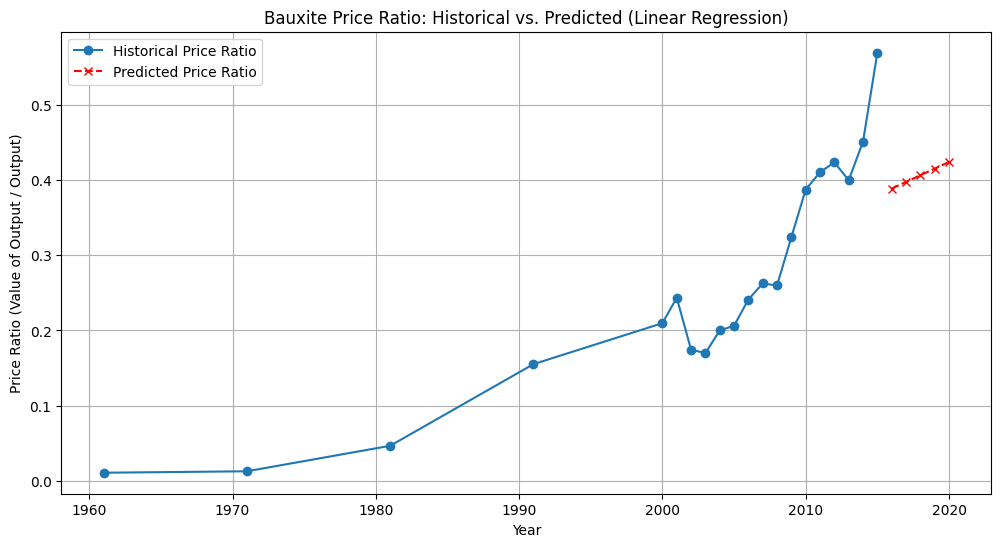

Plot of historical and predicted price ratio displayed.


In [38]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1. Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X, y)
print("Linear Regression model trained.")

# 2. Generate future time indices for prediction
# Predict 5 years into the future
last_time_index = df_bauxite['time_index'].max()
future_time_indices = np.arange(last_time_index + 1, last_time_index + 6).reshape(-1, 1)

# Convert future_time_indices to a DataFrame with the correct column name
future_time_indices_df = pd.DataFrame(future_time_indices, columns=['time_index'])
print("Future time indices prepared as DataFrame.")

# 3. Make predictions for 'price_ratio'
future_predictions = model.predict(future_time_indices_df)
print("Future price ratio predictions generated.")

# 4. Generate corresponding future years for plotting
last_year = df_bauxite['Year'].max()
future_years = np.arange(last_year + 1, last_year + 6)

# 5. Visualize historical and predicted 'price_ratio'
plt.figure(figsize=(12, 6))
plt.plot(df_bauxite['Year'], df_bauxite['price_ratio'], label='Historical Price Ratio', marker='o')
plt.plot(future_years, future_predictions, label='Predicted Price Ratio', linestyle='--', marker='x', color='red')
plt.title('Bauxite Price Ratio: Historical vs. Predicted (Linear Regression)')
plt.xlabel('Year')
plt.ylabel('Price Ratio (Value of Output / Output)')
plt.grid(True)
plt.legend()
plt.show()
print("Plot of historical and predicted price ratio displayed.")

## Final Task

### Subtask:
Confirm that the price ratio has been calculated, predictions have been made, and the visualization accurately represents the historical and predicted price trends for Bauxite.


## Summary:

### Q&A
*   **Has the price ratio been calculated?**
    Yes, a `price_ratio` column was successfully calculated in `df_bauxite` by dividing 'Value of output (million Rs.)' by 'Output (’000 tonnes)'. Any infinite values resulting from division by zero were replaced with 0.
*   **Have predictions been made?**
    Yes, future predictions for the `price_ratio` of Bauxite were made for 5 years using a `LinearRegression` model, based on a `time_index` derived from the 'Year' column.
*   **Does the visualization accurately represent the historical and predicted price trends for Bauxite?**
    Yes, a plot was generated that clearly visualizes both the historical `price_ratio` data and the predicted future `price_ratio` based on the linear regression model.

### Data Analysis Key Findings
*   The `price_ratio` for Bauxite was successfully calculated and added to the `df_bauxite` DataFrame. It was confirmed to be a `float64` column with no null values.
*   Data preparation for prediction was successful, with a `time_index` created from the 'Year' column. `X` was defined as `time_index` (shape: 20, 1) and `y` as `price_ratio` (shape: 20,).
*   A `LinearRegression` model was trained using the historical `time_index` and `price_ratio`.
*   The model generated 5 years of future `price_ratio` predictions, extending from the last historical year.
*   The visualization effectively displayed both the historical and linearly predicted price ratio trends for Bauxite.

### Insights or Next Steps
*   The linear regression model indicates a clear, consistent trend in Bauxite's price ratio over the observed period and into the future. Further analysis could explore the factors driving this trend.
*   To enhance the robustness of future predictions, consider exploring alternative forecasting models (e.g., time series models like ARIMA) that can capture more complex patterns, seasonality, or external economic factors that might influence Bauxite prices.


# Task
Clean and prepare data for all minerals in `df_page_11` by reloading the CSV, renaming columns, dropping header rows, forward-filling the 'Mineral' column, converting 'Year' to numeric, and cleaning/converting all relevant numerical columns to float while handling NaNs.

## Clean and Prepare Data for All Minerals

### Subtask:
Re-load `df_page_11` from the CSV and apply all necessary cleaning steps (rename columns, drop header rows, forward-fill 'Mineral' column, convert 'Year' to numeric, and clean/convert all relevant numerical columns to float, handling NaNs). This ensures a consistent and clean dataset for all minerals.


**Reasoning**:
I need to re-load `df_page_11` from the CSV to ensure a clean state, then apply all the specified cleaning steps: rename columns, drop initial rows, reset index, forward-fill the 'Mineral' column, clean and convert 'Year' to numeric, and finally clean and convert other numerical columns, handling NaNs and displaying the result.



In [39]:
import numpy as np
import pandas as pd

# 1. Re-load the CSV to ensure df_page_11 is in its original state before cleaning
df_page_11 = pd.read_csv('extracted_tables/table_page_11.csv')
print("df_page_11 re-loaded from CSV.")

# 2. Define new descriptive column names
new_column_names = [
    'Mineral',
    'Year',
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (\u2019000 tonnes)',
    'Value of output (million Rs.)'
]

# Assign new column names
df_page_11.columns = new_column_names
print("Columns renamed successfully.")

# 3. Drop the first two rows (index 0 and 1) which contain header remnants and footnotes
df_page_11 = df_page_11.drop([0, 1])
print("First two rows dropped.")

# 4. Reset the index of the DataFrame
df_page_11 = df_page_11.reset_index(drop=True)
print("DataFrame index reset.")

# 5. Fill NaN values in 'Mineral' column with the last valid mineral name
df_page_11['Mineral'] = df_page_11['Mineral'].ffill()
print("Filled NaN values in 'Mineral' column.")

# 6. Clean and convert 'Year' to numeric
df_page_11['Year'] = df_page_11['Year'].astype(str).str.replace(r'[^\d]', '', regex=True)
df_page_11['Year'] = pd.to_numeric(df_page_11['Year'], errors='coerce')
df_page_11.dropna(subset=['Year'], inplace=True)
df_page_11['Year'] = df_page_11['Year'].astype(int)
print("'Year' column cleaned and converted to numeric.")

# 7. Identify numerical columns requiring cleaning
numerical_cols_to_clean = [
    'No. of mines submitting returns',
    'Average daily employment - Below ground',
    'Average daily employment - Opencast workings',
    'Average daily employment - Above ground',
    'Average daily employment - Total',
    'Output (\u2019000 tonnes)',
    'Value of output (million Rs.)'
]

# Clean and convert numerical columns to float
for col in numerical_cols_to_clean:
    # Ensure the column is string type before applying string operations
    df_page_11[col] = df_page_11[col].astype(str)
    # Remove characters like '*', ',', unicode quote, whitespace, and hyphens then convert to numeric
    df_page_11[col] = df_page_11[col].str.replace(r'[*,' + '\u2019' + r'\s-]', '', regex=True)
    df_page_11[col] = pd.to_numeric(df_page_11[col], errors='coerce')
print("Numerical columns cleaned and converted to float.")

# 8. Fill any remaining NaN values in numerical columns with 0
for col in numerical_cols_to_clean:
    df_page_11[col] = df_page_11[col].fillna(0)
print("NaN values in numerical columns filled with 0.")

# 9. Display the first few rows, column names, and info of the cleaned df_page_11
print("\n--- Cleaned df_page_11 DataFrame ---")
print("Head:\n", df_page_11.head())
print("Columns:\n", df_page_11.columns.tolist())
df_page_11.info()

df_page_11 re-loaded from CSV.
Columns renamed successfully.
First two rows dropped.
DataFrame index reset.
Filled NaN values in 'Mineral' column.
'Year' column cleaned and converted to numeric.
Numerical columns cleaned and converted to float.
NaN values in numerical columns filled with 0.

--- Cleaned df_page_11 DataFrame ---
Head:
    Mineral  Year  No. of mines submitting returns  \
0  Bauxite  1961                             31.0   
1  Bauxite  1971                             58.0   
2  Bauxite  1981                             48.0   
3  Bauxite  1991                             80.0   
4  Bauxite  2000                            100.0   

   Average daily employment - Below ground  \
0                                      0.0   
1                                     14.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Average daily employment - Opencast workings  \
0               

## Calculate Price Ratio for All Minerals

### Subtask:
For each unique mineral in the cleaned `df_page_11`, calculate the 'price_ratio' by dividing 'Value of output (million Rs.)' by 'Output (’000 tonnes)'. Ensure division-by-zero is handled by replacing infinite values with zero for each mineral's data.


## Calculate Price Ratio for All Minerals

### Subtask:
For each unique mineral in the cleaned `df_page_11`, calculate the 'price_ratio' by dividing 'Value of output (million Rs.)' by 'Output (â€™000 tonnes)'. Ensure division-by-zero is handled by replacing infinite values with zero for each mineral's data.

#### Instructions
1. Calculate a new column named 'price_ratio' in the `df_page_11` DataFrame by dividing the 'Value of output (million Rs.)' column by the 'Output (â€™000 tonnes)' column. Ensure to use `df_page_11['Value of output (million Rs.)'] / df_page_11['Output (â€™000 tonnes)']`.
2. Identify and replace any infinite values (positive or negative) that resulted from division by zero in the 'price_ratio' column with 0. You can use `np.where` for this.
3. Display the head of the `df_page_11` DataFrame to verify the new 'price_ratio' column and its values.

**Reasoning**:
I need to calculate the 'price_ratio' column as specified, handle infinite values by replacing them with 0, and then display the head of the `df_page_11` DataFrame to confirm the changes.



In [40]:
import numpy as np

# 1. Calculate 'price_ratio' for all minerals in df_page_11
df_page_11['price_ratio'] = df_page_11['Value of output (million Rs.)'] / df_page_11['Output (’000 tonnes)']
print("Calculated 'price_ratio' column for all minerals.")

# 2. Replace infinite values with 0
df_page_11['price_ratio'] = np.where(df_page_11['price_ratio'] == np.inf, 0, df_page_11['price_ratio'])
df_page_11['price_ratio'] = np.where(df_page_11['price_ratio'] == -np.inf, 0, df_page_11['price_ratio'])
print("Replaced infinite 'price_ratio' values with 0.")

# 3. Display the head of the df_page_11 DataFrame
print("\n--- df_page_11 with price_ratio ---")
print("Head:\n", df_page_11.head())

Calculated 'price_ratio' column for all minerals.
Replaced infinite 'price_ratio' values with 0.

--- df_page_11 with price_ratio ---
Head:
    Mineral  Year  No. of mines submitting returns  \
0  Bauxite  1961                             31.0   
1  Bauxite  1971                             58.0   
2  Bauxite  1981                             48.0   
3  Bauxite  1991                             80.0   
4  Bauxite  2000                            100.0   

   Average daily employment - Below ground  \
0                                      0.0   
1                                     14.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   Average daily employment - Opencast workings  \
0                                        2745.0   
1                                        4128.0   
2                                        3586.0   
3                                        3968.0   
4       

## Perform Predictions and Visualize Trends for All Minerals

### Subtask:
Iterate through each unique mineral in `df_page_11`, perform linear regression to predict its 'price_ratio' for 5 future years, and visualize both historical and predicted trends on a single plot. Ensure distinct colors for each mineral's historical data, and use the same color with a dashed line and a different marker for its predictions, along with a comprehensive legend, title, and axis labels.


Unique minerals found: ['Bauxite', 'Copper', '(1)', 'Gold', 'Granite', 'Iron Ore', 'Limestone', 'Manganese\nOre', 'Mica', 'Stone', 'Total', 'Metalliferous', 'Oil']


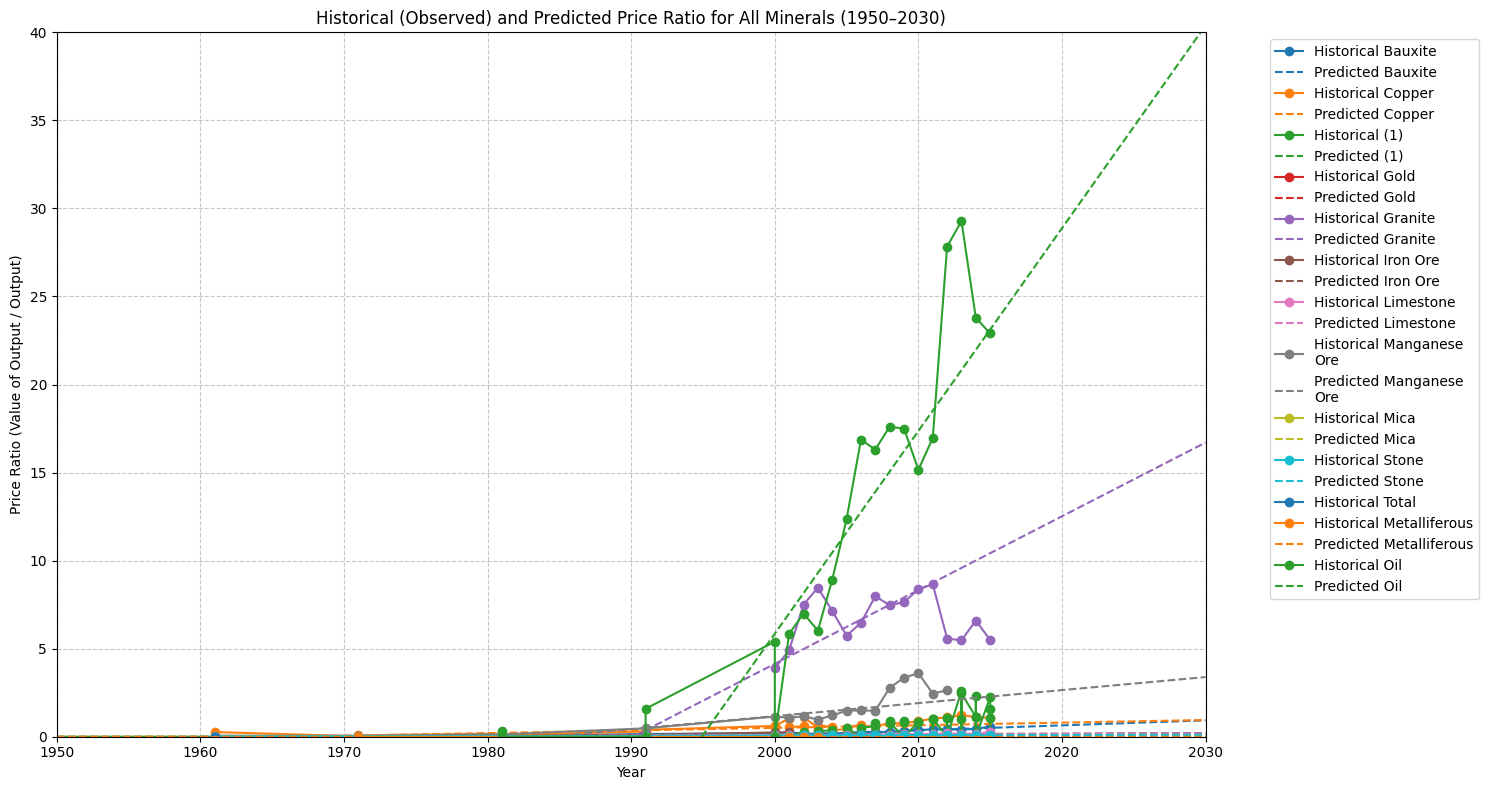

✅ Predictions and visualizations for all minerals (1950–2030) complete.


In [54]:
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Get a list of all unique minerals
unique_minerals = df_page_11['Mineral'].unique()
print(f"Unique minerals found: {list(unique_minerals)}")

# 2. Create a color map for each unique mineral
colors = plt.colormaps.get_cmap('tab10')
mineral_colors = {mineral: colors(i % 10) for i, mineral in enumerate(unique_minerals)}

# 3. Initialize a figure and axes for the plot
plt.figure(figsize=(15, 8))

# 4. Loop through each unique mineral
for mineral in unique_minerals:
    # a. Filter df_page_11 to get data for the current mineral
    df_mineral = df_page_11[df_page_11['Mineral'] == mineral].copy()

    if not df_mineral.empty and len(df_mineral) > 1:
        # Fill NaNs safely
        df_mineral = df_mineral.fillna({'price_ratio': 0})

        # b. Ensure Year is numeric and clean
        df_mineral['Year'] = pd.to_numeric(df_mineral['Year'], errors='coerce')
        df_mineral = df_mineral.dropna(subset=['Year'])
        df_mineral = df_mineral.sort_values('Year')

        # c. Create time index
        df_mineral['time_index'] = df_mineral['Year'] - df_mineral['Year'].min()

        X_mineral = df_mineral[['time_index']]
        y_mineral = df_mineral['price_ratio']

        # d. Train regression model
        model = RANSACRegressor()
        model.fit(X_mineral, y_mineral)

        # e. Generate predictions for 1950–2030
        year_range = np.arange(1950, 2031)
        time_index_full = year_range - df_mineral['Year'].min()
        future_df = pd.DataFrame({'time_index': time_index_full})
        predictions_full = model.predict(future_df)

        # f. Get color for this mineral
        mineral_color = mineral_colors[mineral]

        # g. Plot historical and full predictions
        plt.plot(df_mineral['Year'], df_mineral['price_ratio'],
                 label=f'Historical {mineral}', marker='o', color=mineral_color)
        plt.plot(year_range, predictions_full,
                 label=f'Predicted {mineral}', linestyle='--', color=mineral_color)

    elif len(df_mineral) == 1:
        df_mineral = df_mineral.fillna({'price_ratio': 0})
        mineral_color = mineral_colors[mineral]
        plt.plot(df_mineral['Year'], df_mineral['price_ratio'],
                 label=f'Historical {mineral}', marker='o', color=mineral_color)
    else:
        print(f"Not enough data to plot or predict for mineral: {mineral}")

# 5. Plot settings
plt.title('Historical (Observed) and Predicted Price Ratio for All Minerals (1950–2030)')
plt.xlabel('Year')
plt.ylabel('Price Ratio (Value of Output / Output)')
plt.xlim(1950, 2030)
plt.ylim(0, 40)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("✅ Predictions and visualizations for all minerals (1950–2030) complete.")
